In [1]:
from time import time

import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

from scipy.optimize import curve_fit

from astropy.stats import sigma_clipped_stats, SigmaClip
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils.aperture import EllipticalAperture

from convenience_functions import show_image

from astropy.modeling.models import Sersic2D

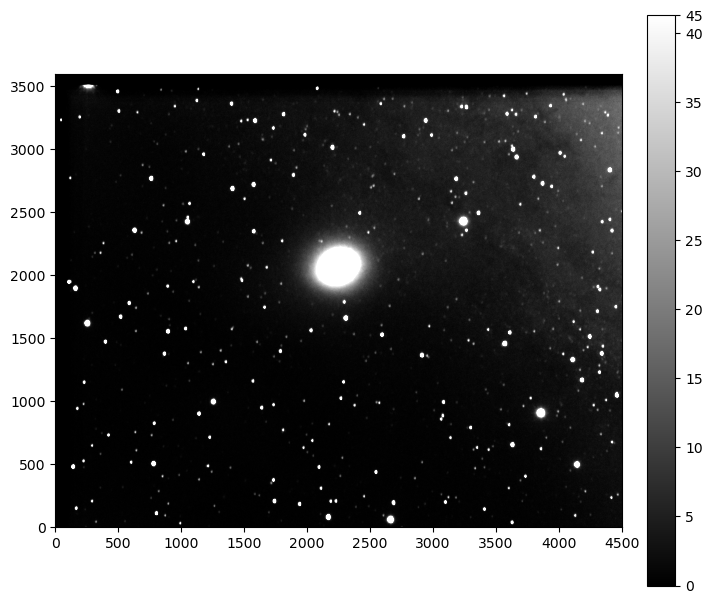

In [2]:
# OPEN IMG AND CHECK IF IT IS RIGHT

# CHANGE the path to wherever the image is
im_to_fit = fits.open("C:/Users/Levente Kardkovács/Documents/Astroweek24/Stacked_by_Levi/M032.FIT")[0].data

show_image(im_to_fit, cmap="gray")

(<matplotlib.patches.Ellipse at 0x201bb2c9a00>,)

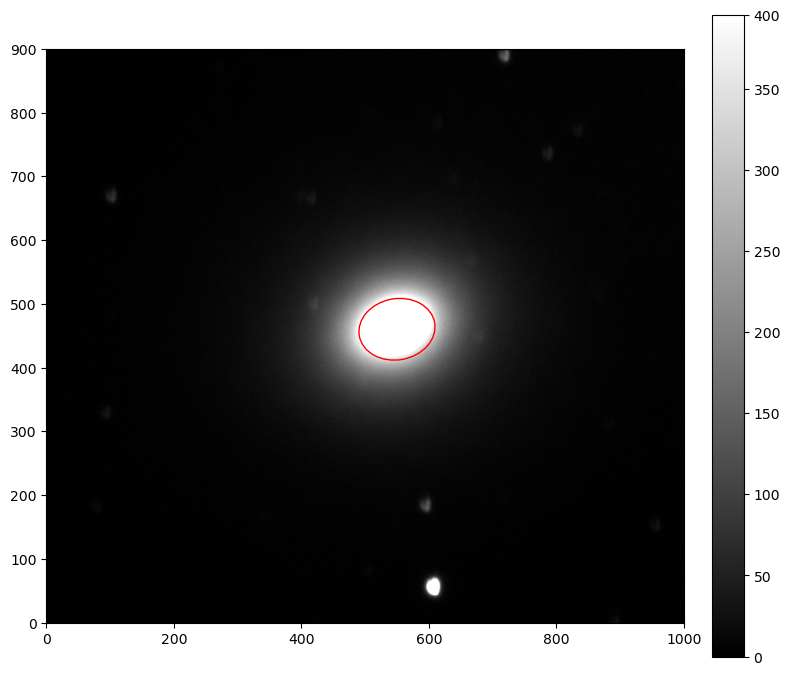

In [56]:
# CALCULATE ISOPHOTES I

xmin, xmax = 1700, 2700
ymin, ymax = 1600, 2500

new_im = im_to_fit[ymin:ymax, :]
new_im = new_im[:, xmin:xmax]

# CHANGE PARAMS HERE (roughly align to galaxy, guiding params for the algorithm)
geometry = EllipseGeometry(x0=550, y0=460, sma=60, eps=0.2, pa=10.0 * np.pi / 180.0) 
# x and y coord. of the center of the galaxy
# semimajor axis length (not the entire galaxy has to be in it, it should be a bit smaller)
# ellipticity
# angle of the ellipse in degrees (change the 10.0)

aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma, geometry.sma * (1 - geometry.eps), geometry.pa)
show_image(new_im, cmap="gray")
aper.plot(color='red')

In [63]:
# CALCULATE ISOPHOTES II

ellipse = Ellipse(new_im, geometry)

In [64]:
t = time()

# CHANGE PARAMS HERE
isolist = ellipse.fit_image(sma0 = 15, step=2, linear=True) 
# semimajor axis of the first isophote to be calculated
# maximum semimajor axis to be calculated (make it larger than the visible part of the galaxy)
# distance between the semimajor of the isophotes to be calculated (adapt to galaxy size, larger for larger sma)

print('Done in: %g s.' % (time() - t))

Done in: 211.071 s.


# Calculate the needed correction for the next cell based on the eccentricity
eps_avg = np.mean(isolist.eps)
ra_ratio = (1-eps_avg**2)**0.25
print(eps_avg)
print(ra_ratio*150)

# Skip every k-th intensity for high ellipticity to adjust it to radius instead of sma

"""
def skip_elements(arr, k):
    return [arr[i] for i in range(len(arr)) if (i + 1) % k != 0]

k = 0
if k < 1e-14:
    isolist_ri = isolist.intens
    isolist_r = isolist.sma
else:
    isolist_ri = skip_elements(isolist.intens, k)
    isolist_r = skip_elements(isolist.sma, k)
    
isolist_r = isolist.sma*ra_ratio
isolist_ri = isolist.intens/ra_ratio
"""

if k < 1e-14:
    N = 2*len(isolist_ri) - 1
else:
    N = 2*(len(isolist_ri) - len(isolist_ri)//k + 2)


In [24]:
def circumference(a_, b_):
    a_ = a_[1:]
    b_ = b_[1:]
    h = (a_-b_)**2/(a_+b_)**2
    c = np.pi*(a_+b_)*(1+3*h/(10+np.sqrt(4-3*h)))
    c = np.append([0], c)
    return c

a = isolist.sma
b = isolist.sma*np.sqrt(1-isolist.eps**2)
r = np.sqrt(a*b)

I_tot = np.sum(isolist.intens*circumference(a, b))
for i in range(1, len(isolist.sma)):
    if np.sum(isolist.intens[:i]*circumference(isolist.sma[:i], isolist.sma[:i]*np.sqrt(1-isolist.eps[:i]**2)))/I_tot > 0.5:
        r_e = r[i]#/np.sqrt(1-isolist.eps[i])
        i_e = isolist.sma[i]
        break
print(r_e)
print(i_e)

75.08043621559088
76.0


In [65]:
# SHOW INTENSITY (you can ignore this, it just shows the max radius the intensity was calculated for and the intensities)
print(isolist.sma[-1])
print(isolist.intens)
plt.scatter(isolist.sma, isolist.intens)

383.0
[7.00244155e+03 6.96855098e+03 6.64159230e+03 6.28468475e+03
 5.61536987e+03 4.70085849e+03 3.84371780e+03 3.04778648e+03
 2.48043155e+03 2.09749806e+03 1.82242893e+03 1.61630980e+03
 1.44582189e+03 1.30510381e+03 1.18430786e+03 1.08245555e+03
 9.93713619e+02 9.11743125e+02 8.45749453e+02 7.81518797e+02
 7.28306281e+02 6.78695088e+02 6.37502708e+02 5.96856534e+02
 5.61106923e+02 5.30485694e+02 5.01079650e+02 4.73764019e+02
 4.48673202e+02 4.25195658e+02 4.04101348e+02 3.83031860e+02
 3.63583648e+02 3.47174248e+02 3.31631158e+02 3.15442731e+02
 3.00777012e+02 2.87327757e+02 2.75020314e+02 2.62974985e+02
 2.52479446e+02 2.42087442e+02 2.31769003e+02 2.22447794e+02
 2.11760443e+02 2.03878347e+02 1.95608988e+02 1.87976680e+02
 1.80220917e+02 1.72730820e+02 1.66141893e+02 1.59540479e+02
 1.53720404e+02 1.47437539e+02 1.42119710e+02 1.36722818e+02
 1.31630613e+02 1.26827571e+02 1.21967241e+02 1.17152398e+02
 1.12749253e+02 1.09010077e+02 1.05470970e+02 1.01375304e+02
 9.79338516e+01 9.

In [ ]:
# CALCULATE SÉRSIC FIT

# Fit an arbitrary function to the isophotes
#def lcurve(R, n, R_e, I_e):
 #   b_n = 2*n-1/3
 #   return I_e*np.exp(-b_n*((R/R_e)**(1/n)-1))

#N = 2*len(isolist.sma)
#coord = np.array([np.arange(geometry.x0+2, geometry.x0 + N, 2), np.arange(geometry.y0+2, geometry.y0 + N, 2)])
#def lcurve2(x, n):
#    rhs = ((isolist.sma[1:]/r_e)**(1/n)-1)/(np.sqrt(1-isolist.eps[1:]**2)*(isolist.sma[1:]/r_e)**(1/n)-1)
#    sers = Sersic2D.evaluate(x=x[0, :], y=x[1, :], amplitude=i_e, r_eff=r_e, n=n, 
#                             x_0=np.mean(isolist.x0), y_0=np.mean(isolist.y0), 
#                             ellip=np.mean(isolist.eps), theta=np.mean(isolist.pa))*np.exp(rhs)
#    return sers

In [66]:
t = time()
# Fit the function to the data
#params, covariance = curve_fit(lcurve, isolist.sma[20:], isolist.intens[20:], [4, 50, 100], maxfev=10000)
#params, covariance = curve_fit(lcurve2, coord, isolist.intens[1:], [4], maxfev=10000

X, Y = np.meshgrid(np.arange(0, xmax-xmin), np.arange(0, ymax-ymin))
size = X.shape
x_1d = X.ravel()
y_1d = Y.ravel()

def full(pic, n, Ie, Re, pa, eps, x0, y0):
    mod = Sersic2D(amplitude=Ie, r_eff=Re, n=n, x_0=x0, y_0=y0, ellip=eps, theta=pa * np.pi / 180.0)
    guess = mod(pic[0], pic[1])
    tbf = guess.ravel()
    return tbf

def full_red(pic, n, Ie, Re):
    mod = Sersic2D(amplitude=Ie, r_eff=Re, n=n, x_0=np.mean(isolist.x0), y_0=np.mean(isolist.y0), 
                   ellip=np.mean(isolist.eps), theta=np.mean(isolist.pa) * np.pi / 180.0)
    guess = mod(pic[0], pic[1])
    tbf = guess.ravel()
    return tbf

xdata = np.vstack((x_1d, y_1d))
ydata = new_im.ravel()
#params, covariance = curve_fit(full, xdata, ydata, [4, 100, 500, 30, 0.1, 2250, 2050], maxfev=1000)
params, covariance = curve_fit(full_red, xdata, ydata, [4, 100, 500], maxfev=1000)
print('Done in: %g s.' % (time() - t))

# Print the fitted parameters
print("Fitted Parameters:")
#print("n:", params[0], "pm", np.sqrt(np.diag(covariance)[0]))
#print("Ie:", params[1], "pm", np.sqrt(np.diag(covariance)[1]))
#print("Ie:", params[2], "pm", np.sqrt(np.diag(covariance)[2]))
#print("pa:", params[3], "pm", np.sqrt(np.diag(covariance)[3]))
#print("pa:", params[4], "pm", np.sqrt(np.diag(covariance)[4]))
print(params)

Done in: 3.76646 s.
Fitted Parameters:
[  1.82604091 451.31976244  56.11128468]


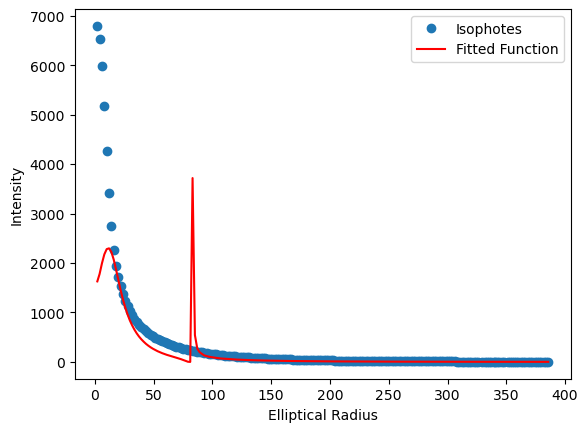

In [27]:
# Plot the original isophotes and the fitted function
fig, ax = plt.subplots()
#ax.set_yscale("log")
ax.plot(r[1:], isolist.intens[1:], 'o', label='Isophotes')
ax.plot(r[1:], lcurve2(coord, *params), label='Fitted Function', color='red')
ax.set_xlabel('Elliptical Radius')
ax.set_ylabel('Intensity')
ax.legend()
plt.show()

In [75]:
# BUILD MODEL

X, Y = np.meshgrid(np.arange(0, xmax-xmin), np.arange(0, ymax-ymin))
#model = Sersic2D(amplitude=i_e, r_eff=r_e, n=params[0], x_0=np.mean(isolist.x0), y_0=np.mean(isolist.y0), 
#                 ellip=np.mean(isolist.eps), theta=np.mean(isolist.pa))
model = Sersic2D(amplitude=params[1], r_eff=params[2], n=params[0], x_0=np.mean(isolist.x0), y_0=np.mean(isolist.y0), 
                 ellip=np.mean(isolist.eps), theta=np.mean(isolist.pa))

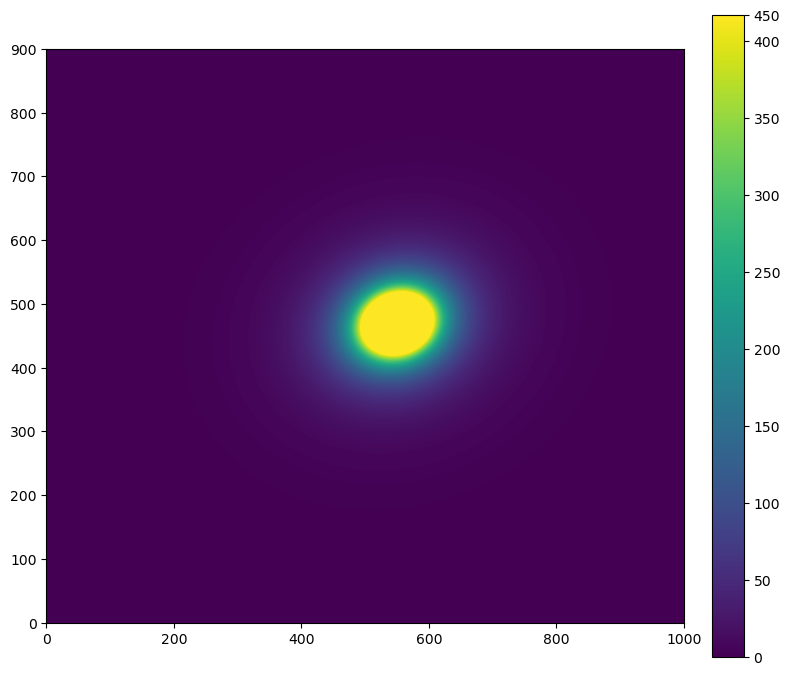

In [76]:
show_image(model(X, Y))

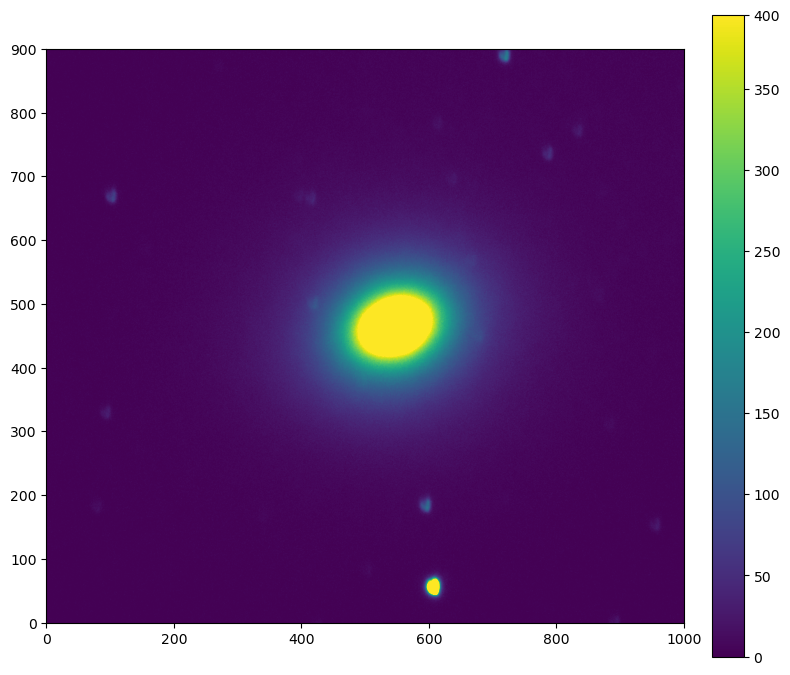

In [77]:
show_image(new_im)

In [78]:
show_image((new_im-model(X,Y))**2)

In [ ]:
# BUILD MODEL

t = time()
model_image = build_ellipse_model(im_to_fit.shape, isolist)
print('Done in: %g s.' % (time() - t))
residual = im_to_fit - model_image

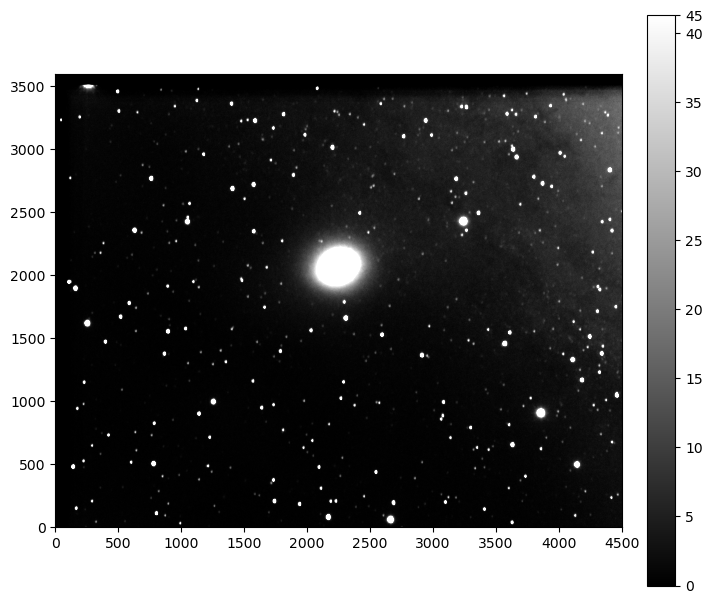

In [22]:
# SHOW MODEL
show_image(im_to_fit, cmap="gray")
show_image(model_image, cmap='gray')
show_image(residual, cmap="gray")

In [27]:
import ccdproc as ccdp
from astropy.nddata import CCDData
from pathlib import Path

test_raw = ccdp.ImageFileCollection("C:/Users/Levente Kardkovács/Documents/Astroweek24/M032")
im = CCDData.read(Path("C:/Users/Levente Kardkovács/Documents/Astroweek24/M032")/test_raw.files[0], unit="count")

In [34]:
test_raw.summary

<Table masked=True length=30>
    file     simple bitpix ... response                 note                
   str12      bool  int32  ... float64                 str36                
------------ ------ ------ ... -------- ------------------------------------
M032_001.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:02:54.000
M032_002.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:03:36.000
M032_003.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:04:19.000
M032_004.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:05:01.000
M032_005.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:05:44.000
M032_006.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:06:26.000
M032_007.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:07:09.000
M032_008.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:07:51.000
M032_009.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:08:34.000
M032_010.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:09:16.000
         ...    ...    ... ...      ...                                  ...
M032_021.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:17:03.000
M032_022.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:17:45.000
M032_023.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:18:28.000
M032_024.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:19:10.000
M032_025.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:19:53.000
M032_026.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:20:35.000
M032_027.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:21:17.000
M032_028.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:22:00.000
M032_029.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:22:42.000
M032_030.FIT   True     16 ...   3000.0 Local time:1/11/2024 at 12:23:25.000

In [50]:
np.max(im.data[2000:2100, 2200:2300])

9989

In [49]:
show_image(im.data[2000:2100, 2200:2300], cmap="gray") # bone is okay too